# USING BAYESIAN OPTIMIZATION FOR HYPERPARAMETER TUNING


- Authors: Beltrán Aller López and Miguel López Garralón
- Date: 13/12/2019
- Email: beltran.aller@cunef.edu and m.lopez@cunef.edu
- Institution: CUNEF
- Version: 1.0

Before doing anything, we will import the necessaries libraries.

In [2]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt # plots
import seaborn as sns # plots
from scipy import stats as sts # normality test JB
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import Ridge, RidgeCV # Ridge
from sklearn.linear_model import Lasso, LassoCV # Lasso
from sklearn.linear_model import LogisticRegression # Log Regression
from sklearn.metrics import r2_score # R^2
from sklearn.model_selection import train_test_split # split data
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error # MSE
from sklearn.preprocessing import StandardScaler # estandarization
from sklearn import preprocessing # estandarization
from sklearn.ensemble import IsolationForest # outliers
from math import sqrt # sqrt
import itertools # aplanar arrays
import math
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC # SVM
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier #XGBoost
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve # ROC Curve
from sklearn.datasets import make_classification
import random
random.seed(1122019)
import pickle

The following variable indicates the route in which we have our dataset.

In [3]:
data_path = '../data/PCA_set.csv'

## 1. READING THE DATA

The dataset is kept into the data directory. In the same folder you can find the data dictionary.

In [4]:
loan = pd.read_csv(data_path)

In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950000 entries, 0 to 949999
Data columns (total 42 columns):
Component_1                            950000 non-null float64
Component_2                            950000 non-null float64
Component_3                            950000 non-null float64
Component_4                            950000 non-null float64
Component_5                            950000 non-null float64
Component_6                            950000 non-null float64
Component_7                            950000 non-null float64
Component_8                            950000 non-null float64
Component_9                            950000 non-null float64
Component_10                           950000 non-null float64
Component_11                           950000 non-null float64
Component_12                           950000 non-null float64
Component_13                           950000 non-null float64
Component_14                           950000 non-null float64
Compone

## 2. MODELING

We modify our exogenous variables including the categories of the dummies that we have deleted before whe we went to do the lasso regression.

In [6]:
X = loan.drop(['target'], axis = 1).values
Y = loan['target'].values

To do the logistic regression (and the other methods) we have to split the dataset into two parts, train and test. We know that the dataset is imbalanced, we have a lot of cases of non default and a few cases os default in comparisson. To solve that problem, we will apply a method of oversampling called Smote. Smote function creates synthetic samples of the minority class making the minority class equal to the majority class. To do that Smote selects similar records.

In [7]:
sm = SMOTE(random_state=40, sampling_strategy = 0.4)
X_train, Y_train = sm.fit_sample(X, Y)
print(X_train.shape); 

(1055384, 41)


Realise that we only do that over the train, the test must stay with the original distribution.

In [8]:
ytrain_df = pd.DataFrame(Y_train, columns = ['target'])

In [9]:
xtrain_df = pd.DataFrame(X_train, columns = list(loan.drop(['target'], axis = 1).columns))

In [10]:
ytrain_df.head(10)

,target
0,0
1,0
2,0
3,0
4,1
5,1
6,0
7,0
8,0
9,0


Here we can see the distribution of defaults and non defaults in the training set.

In [11]:
data_smoted = pd.concat([xtrain_df, ytrain_df], axis = 1)
data_smoted.to_csv('../data/data_smoted.csv')

In [12]:
ytrain_df['target'].value_counts(normalize=True)

0    0.714286
1    0.285714
Name: target, dtype: float64

In [13]:
def save_models(filename, model):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# What is Bayesian Optimization?

Recently, few libraries have been developed to implement Bayesian Methods for hyperparameter tuning, which is a crucial task if you want to get the best performance of a model.

Bayesian optimization finds the value that minimizes an objective function by building a surrogate function.

Bayesian methods differ from random or grid search in that they use past evaluation results to choose the next values to evaluate.

In the case of hyperparameter optimization, the objective function is the validation error of a machine learning model using a set of hyperparameters. The aim is to find the hyperparameters that yield the lowest error on the validation set in the hope that these results generalize to the testing set.

# Support Vector Machine

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

There we define our set of parameters that are being tuned.

In [13]:
param_svm= {'C': (1, 10), 'gamma': (1, 10)}

Also we need to make the surrogate function which is going to be optimized. We define a SVM classifier with the maximun of iteration and the kerner function defined by default and the set of parameters we want tuning.

The aim is to maximized the AUC and minimized the error on the validation set to use the model at the test set later.

In [14]:
def svm_hyper_param(C, gamma):
 
    clf = SVC(
        max_iter= 1000,
        C=C,
        kernel='linear',
        gamma=gamma)
    
    return np.mean(cross_val_score(clf, X_train, Y_train, cv=3, scoring='roc_auc'))

In [15]:
%%time

optimizer_svm = BayesianOptimization(
    f=svm_hyper_param,
    pbounds=param_svm,
    random_state=1,
)

optimizer_svm.maximize(n_iter = 10)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  1        |  0.7544   |  4.753    |  7.483    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  2        |  0.7456   |  1.001    |  3.721    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  3        |  0.7514   |  2.321    |  1.831    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  4        |  0.7542   |  2.676    |  4.11     |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  5        |  0.7544   |  4.571    |  5.849    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  6        |  0.7544   |  10.0     |  1.0      |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  7        |  0.7544   |  10.0     |  10.0     |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  8        |  0.7544   |  8.988    |  5.179    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  9        |  0.7544   |  6.198    |  1.005    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  10       |  0.7544   |  5.455    |  9.999    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  11       |  0.7544   |  7.334    |  5.164    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  12       |  0.7544   |  7.275    |  9.995    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  13       |  0.7544   |  7.124    |  1.0      |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  14       |  0.7544   |  7.561    |  5.563    |


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


|  15       |  0.7544   |  7.089    |  9.996    |
Wall time: 26min 53s


Here we have the best hyperparameters of our SVM.

In [21]:
optimizer_svm.max

{'target': 0.7543539191817437,
 'params': {'C': 4.753198042323167, 'gamma': 7.482920440979423}}

In [22]:
%%time
gsearch_SVM2 = SVC(max_iter=1000, C=4.753198042323167, kernel='linear', gamma=7.482920440979423)
gsearch_SVM2.fit(X_train, Y_train)

Wall time: 2min


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=4.753198042323167, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=7.482920440979423,
    kernel='linear', max_iter=1000, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [23]:
save_models('../src/Models/PCA_BO/svm_regression', gsearch_SVM2)

The method implemented for the SVM is going to be replicated on the other models.

# Random Forest

Random Forest, in this case, is a method for classification using an ensamble of many different decision trees. In this method the decision to classify in one class or in other comes frome making the mean of the results of all the decision trees. Random Forest has small variance and is difficult to have overfitting. We use this method because a unique decision tree is so unstable and, for that reason, we train the model with a lot of decision tress.

In [24]:
param_randomf= {'max_depth' : (2,8), 'verbose': (0,1), 'cc_alpha': (0,1)}

In [25]:
def randomf_hyper_param(max_depth, verbose, cc_alpha):
 
    clf = RandomForestClassifier(
        n_estimators=500,
        bootstrap=True,
        max_depth=max_depth,
        criterion='gini',
        n_jobs=-1,
        verbose=verbose,
        ccp_alpha=cc_alpha,
        max_features='auto'
    )
    
    return np.mean(cross_val_score(clf, X_train, Y_train, cv=3, scoring='roc_auc'))

In [26]:
%%time

optimizer_randomf = BayesianOptimization(
    f=randomf_hyper_param,
    pbounds=param_randomf,
    random_state=1,
)

optimizer_randomf.maximize(n_iter = 10)

|   iter    |  target   | cc_alpha  | max_depth |  verbose  |
-------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 218 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 218 tas

|  1        |  0.5      |  0.417    |  6.322    |  0.000114 |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 214 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 214 tas

|  2        |  0.5      |  0.3023   |  2.881    |  0.09234  |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 201 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 201 tas

|  3        |  0.5      |  0.1863   |  4.073    |  0.3968   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 455 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 189 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 455 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min fi

|  4        |  0.5      |  0.5388   |  4.515    |  0.6852   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 217 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 217 tas

|  5        |  0.5      |  0.2045   |  7.269    |  0.02739  |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 428 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 428 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 428 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min fi

|  6        |  0.5      |  0.4548   |  2.019    |  0.9845   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 429 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.5min fi

|  7        |  0.5      |  0.9248   |  7.989    |  0.9699   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  35 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 209 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  35 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 209 tas

|  8        |  0.5      |  0.4566   |  7.986    |  0.2152   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 455 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 189 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 455 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 455 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min fi

|  9        |  0.5      |  0.231    |  2.038    |  0.6924   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 427 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 427 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 427 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min fi

|  10       |  0.5      |  0.8741   |  2.001    |  0.9951   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 tas

|  11       |  0.5      |  0.9826   |  7.99     |  0.2582   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 181 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 437 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min fi

|  12       |  0.5      |  0.6968   |  2.028    |  0.8854   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 463 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min fi

|  13       |  0.5      |  0.7425   |  7.967    |  0.6052   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 181 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 437 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min fi

|  14       |  0.5      |  0.8243   |  2.135    |  0.879    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 428 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 428 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 428 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min fi

|  15       |  0.5      |  0.33     |  7.933    |  0.9861   |
Wall time: 2h 3min 12s


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    1.5s finished


In [27]:
optimizer_randomf.max

{'target': 0.5,
 'params': {'cc_alpha': 0.417022004702574,
  'max_depth': 6.321946960652949,
  'verbose': 0.00011437481734488664}}

Here we have the best hyperparameters of our Random Forest model.

In [28]:
%%time
gsearch_RandomForest2 = RandomForestClassifier(
        n_estimators=500,
        bootstrap=True,
        max_depth=6.321946960652949,
        criterion='gini',
        n_jobs=-1,
        verbose=0.00011437481734488664,
        ccp_alpha=0.417022004702574,
        max_features='auto'
    )
gsearch_RandomForest2.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  2.7min


Wall time: 5min 54s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.417022004702574,
                       class_weight=None, criterion='gini',
                       max_depth=6.321946960652949, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0.00011437481734488664, warm_start=False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


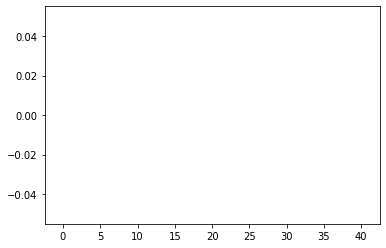

In [29]:
print(gsearch_RandomForest2.feature_importances_)

list(gsearch_RandomForest2.feature_importances_)

plt.bar(range(len(gsearch_RandomForest2.feature_importances_)), gsearch_RandomForest2.feature_importances_)
plt.show()

In [30]:
pd.DataFrame(gsearch_RandomForest2.feature_importances_, loan.drop('target', axis=1).columns, columns = ['Importance'])

,Importance
Component_1,0.0
Component_2,0.0
Component_3,0.0
Component_4,0.0
Component_5,0.0
Component_6,0.0
Component_7,0.0
Component_8,0.0
Component_9,0.0
Component_10,0.0


In [31]:
save_models('../src/Models/PCA_BO/random_forest_regression', gsearch_RandomForest2)

# XGBoost

XGBoost is a method for classification similar to the Random Forest model, that uses an ensamble of many different decision trees. The difference with the Random Forest is that XGBoost has more variance, it could have problems with overfitting and it usually has more accuracy with less number of estimators. In this method the cases that have failed previously in their classification have more importance for the model, so they are used again in next samples to try to classify them correctly.

In [14]:
param_xgboost= {'learning_rate': (0.01, 1.0),
    'gamma': (0, 5)}

In [15]:
def xgboost_hyper_param(learning_rate, gamma):
 
    clf = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=500,
        gamma=gamma,
        n_jobs=-1)
    
    return np.mean(cross_val_score(clf, X_train, Y_train, cv=3, scoring='roc_auc'))

In [16]:
%%time

optimizer_xgboost = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=param_xgboost,
    random_state=1,
)

optimizer_xgboost.maximize(n_iter = 5)

|   iter    |  target   |   gamma   | learni... |
-------------------------------------------------
|  1        |  0.9138   |  2.085    |  0.7231   |
|  2        |  0.9122   |  0.000571 |  0.3093   |
|  3        |  0.8971   |  0.7338   |  0.1014   |
|  4        |  0.9129   |  0.9313   |  0.3521   |
|  5        |  0.915    |  1.984    |  0.5434   |
|  6        |  0.8396   |  5.0      |  0.01     |
|  7        |  0.9104   |  8.87e-12 |  1.0      |
|  8        |  0.9105   |  5.0      |  1.0      |
|  9        |  0.9112   |  3.878    |  1.0      |
|  10       |  0.9109   |  1.215    |  1.0      |
Wall time: 47min 24s


In [17]:
optimizer_xgboost.max

{'target': 0.914974468199992,
 'params': {'gamma': 1.9838373711533497, 'learning_rate': 0.5434285666633234}}

Here we have the best hyperparameters of our XGBoost Model.

In [18]:
%%time
gsearch_XGBoost2 = XGBClassifier(
        learning_rate=0.5434285666633234,
        n_estimators=500,
        gamma=1.9838373711533497,
        n_jobs=-1)
gsearch_XGBoost2.fit(X_train, Y_train)

Wall time: 4min 24s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.9838373711533497,
              learning_rate=0.5434285666633234, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

[0.00214114 0.00928956 0.00936462 0.0014107  0.01539603 0.00569542
 0.00349576 0.01625108 0.03268584 0.00716612 0.00909483 0.01815542
 0.004369   0.00387766 0.00668376 0.00098353 0.00265886 0.00138485
 0.00227743 0.00169288 0.00148777 0.03174262 0.         0.05130685
 0.         0.01933466 0.10440277 0.15968698 0.06209258 0.08652367
 0.04393867 0.1404726  0.00579146 0.01049324 0.0016253  0.00180238
 0.02712587 0.00777239 0.         0.00949442 0.08083127]


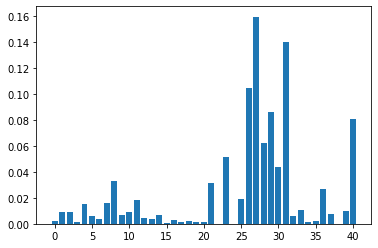

In [19]:
print(gsearch_XGBoost2.feature_importances_)

list(gsearch_XGBoost2.feature_importances_)

plt.bar(range(len(gsearch_XGBoost2.feature_importances_)), gsearch_XGBoost2.feature_importances_)
plt.show()

In [20]:
pd.DataFrame(gsearch_XGBoost2.feature_importances_, loan.drop('target', axis=1).columns, columns = ['Importance'])

,Importance
Component_1,0.002141
Component_2,0.009290
Component_3,0.009365
Component_4,0.001411
Component_5,0.015396
Component_6,0.005695
Component_7,0.003496
Component_8,0.016251
Component_9,0.032686
Component_10,0.007166


In [21]:
save_models('../src/Models/PCA_BO/xgboost_regression',gsearch_XGBoost2)

# Conclusions

Bayesian Optmization presents some limitations:
* It does not run correctly over Random Forest.
* As far as we know it does not allow tuning hyperparameters that are not numerical.
* The library used is so new and it does not contain the enough documentation about what the code does especifically, although teorically we know how Bayesian Methods run. Maybe the problems observed at Random Forest could be solved if we have more knowledge about internal running of the function.

Bayesian Optimization shows some advantages:
* Is faster than Sear Grid.
* Bayesian hyperparameter tuning uses a continually updated probability model to “concentrate” on promising hyperparameters by reasoning from past results.

# References:

* https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
* https://machinelearningmastery.com/what-is-bayesian-optimization/
* https://github.com/fmfn/BayesianOptimization
* https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/